In [1]:
# Capture Emotions
import cv2
import os
import uuid

# Define base path and labels
base_path = '../Dataset/Photos'
labels = ['Neutral', 'Angry', 'Happy', 'Disgust', 'Sad', 'Surprise', 'Fear']

# Create directories if they don't exist
for label in labels:
    os.makedirs(os.path.join(base_path, label), exist_ok=True)

# Map keypresses to emotion labels
key_map = {
    'n': 'Neutral',
    'a': 'Angry',
    'h': 'Happy',
    'd': 'Disgust',
    's': 'Sad',
    'p': 'Surprise',
    'f': 'Fear'
}

# Start webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    # Ensure the frame is large enough
    if frame.shape[0] < 370 or frame.shape[1] < 450:
        print("Frame size too small for cropping.")
        continue

    # Crop frame to 250x250 pixels
    frame = frame[120:370, 200:450]

    # Display the cropped frame
    cv2.imshow('Image Collection', frame)

    # Read keypress once
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break

    elif chr(key) in key_map:
        emotion = key_map[chr(key)]
        imgname = os.path.join(base_path, emotion, f'{uuid.uuid1()}.jpg')
        cv2.imwrite(imgname, frame)
        print(f'[INFO] Saved: {imgname}')

# Release resources
cap.release()
cv2.destroyAllWindows()


[INFO] Saved: ../Dataset/Photos\Neutral\6a4e8086-58f3-11f0-a7d3-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\6c0d6bf8-58f3-11f0-9875-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\6c9f3b3a-58f3-11f0-84be-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\6d689f2b-58f3-11f0-9fcd-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\6e18815f-58f3-11f0-a4c9-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\7051140f-58f3-11f0-af92-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\71643e55-58f3-11f0-87b2-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\725bc0b7-58f3-11f0-b42e-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\73249278-58f3-11f0-a0bc-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\73c0af59-58f3-11f0-8d7a-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\7442ea51-58f3-11f0-a673-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Photos\Neutral\74e670d9-58f3-11f0-8bb8-a05950381cf5.jpg
[INFO] Saved: ../Dataset/Pho

In [1]:
# Dataset preprocessing (MTCNN)
import os
from PIL import Image
from tqdm import tqdm
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms
from pathlib import Path
import torch

# ------------------------------
# Configuration
# ------------------------------
input_root = "../Dataset/Photos"
output_root = "../Dataset/Processed_Photos"
suspect_root = "../Dataset/Suspect_Faces"
image_size = 112
min_face_size = 90  # for quality check

# ------------------------------
# Helper function
# ------------------------------
def is_low_quality(face_tensor, min_size=90):
    """Check if the detected face is too small or oddly shaped."""
    h, w = face_tensor.shape[1], face_tensor.shape[2]
    if h < min_size or w < min_size:
        return True
    aspect_ratio = w / h
    if aspect_ratio < 0.7 or aspect_ratio > 1.3:
        return True
    return False

# ------------------------------
# Initialize MTCNN
# ------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=image_size, margin=10, post_process=True, device=device)

# ------------------------------
# Logging file
# ------------------------------
log_file = open("suspect_faces_log.txt", "a")

# ------------------------------
# Processing Loop
# ------------------------------
expression_dirs = [d for d in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, d))]

for expression in expression_dirs:
    input_dir = os.path.join(input_root, expression)
    output_dir = os.path.join(output_root, expression)
    suspect_dir = os.path.join(suspect_root, expression)

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(suspect_dir, exist_ok=True)

    images = [img for img in os.listdir(input_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for img_name in tqdm(images, desc=f"Processing {expression}"):
        input_path = os.path.join(input_dir, img_name)
        output_path = os.path.join(output_dir, img_name)
        suspect_path = os.path.join(suspect_dir, img_name)

        try:
            img = Image.open(input_path).convert('RGB')
            face = mtcnn(img)

            if face is not None:
                if is_low_quality(face, min_size=min_face_size):
                    # Save as suspect
                    face = face * 128 + 127.5
                    face = face.clamp(0, 255).byte()
                    face_img = transforms.ToPILImage()(face).convert("L")
                    face_img.save(suspect_path)
                    log_file.write(f"LOW_QUALITY: {expression}/{img_name}\n")
                else:
                    # Save clean processed face
                    face = face * 128 + 127.5
                    face = face.clamp(0, 255).byte()
                    face_img = transforms.ToPILImage()(face).convert("L")
                    face_img.save(output_path)
            else:
                # No face detected
                img.save(suspect_path)
                log_file.write(f"NO_FACE: {expression}/{img_name}\n")

        except Exception as e:
            print(f"[!] Error processing {img_name}: {e}")
            log_file.write(f"ERROR: {expression}/{img_name} - {e}\n")

log_file.close()
print("\n✅ Preprocessing complete. Suspect images and log saved.")


c:\users\prince yadav\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing Surprise: 100%|███████████████████████████████████████████████████████████| 212/212 [00:15<00:00, 13.92it/s]


✅ Preprocessing complete. Suspect images and log saved.


In [2]:
import os
from PIL import Image
from tqdm import tqdm
from facenet_pytorch import InceptionResnetV1, MTCNN
import torch
from sklearn.cluster import KMeans
import numpy as np
from shutil import copyfile

In [3]:
photos_root = '../Dataset/Processed_Photos'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_clusters = 22
# Model initialization
mtcnn = MTCNN(image_size=112, margin=10, device=device).eval()
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Storage for embeddings and paths
image_paths = []
embeddings = []

print("[INFO] Processing images and extracting embeddings...")

# Traverse expression folders
for expression in os.listdir(photos_root):
    exp_path = os.path.join(photos_root, expression)
    if not os.path.isdir(exp_path):
        continue

    for img_name in os.listdir(exp_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(exp_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')

            with torch.no_grad():
                face = mtcnn(img)

            if face is not None:
                face = face.unsqueeze(0).to(device)

                with torch.no_grad():
                    embedding = resnet(face).cpu().numpy()[0]

                embeddings.append(embedding)
                image_paths.append(img_path)
            else:
                print(f"[WARNING] No face detected in: {img_name}")

        except Exception as e:
            print(f"[ERROR] Processing {img_name}: {e}")

print(f"\n✅ Done. {len(embeddings)} embeddings extracted.")


[INFO] Processing images and extracting embeddings...
[WARNING] No face detected in: 7e457959-55a0-11f0-b34d-c44c1cfa3745.jpg
[WARNING] No face detected in: 83684583-55a0-11f0-bd6d-c44c1cfa3745.jpg
[WARNING] No face detected in: 8547e7b9-55a0-11f0-a0cf-c44c1cfa3745.jpg
[WARNING] No face detected in: 929514e2-55a0-11f0-8519-c44c1cfa3745.jpg
[WARNING] No face detected in: 93be9e7f-55a0-11f0-ae0f-c44c1cfa3745.jpg
[WARNING] No face detected in: a2426aab-576d-11f0-9cc2-40ec99dc562b.jpg

✅ Done. 1652 embeddings extracted.


In [4]:
from sklearn.cluster import KMeans

# Number of people (estimated identities)
num_clusters = 22  # Adjust based on your dataset

print("[INFO] Clustering embeddings...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(embeddings)


[INFO] Clustering embeddings...


In [5]:
import shutil

cluster_output = '../Dataset/Processed_Identity'
os.makedirs(cluster_output, exist_ok=True)

# Create subfolders for each identity cluster
for cluster_id in range(num_clusters):
    os.makedirs(os.path.join(cluster_output, f'Identity_{cluster_id}'), exist_ok=True)

# Save images to corresponding identity folders
print("[INFO] Saving clustered images...")

for img_path, cluster_id in zip(image_paths, cluster_ids):
    img_name = os.path.basename(img_path)
    dest_path = os.path.join(cluster_output, f'Identity_{cluster_id}', img_name)
    shutil.copy(img_path, dest_path)

print(f"\n✅ Done. Clustered images saved to: {cluster_output}")


[INFO] Saving clustered images...

✅ Done. Clustered images saved to: ../Dataset/Processed_Identity


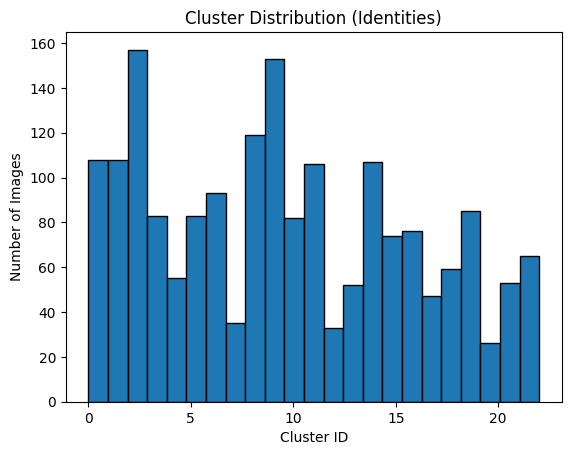

In [39]:
import matplotlib.pyplot as plt

plt.hist(cluster_ids, bins=num_clusters, edgecolor='black')
plt.title("Cluster Distribution (Identities)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Images")
plt.show()


[INFO] Running t-SNE dimensionality reduction...


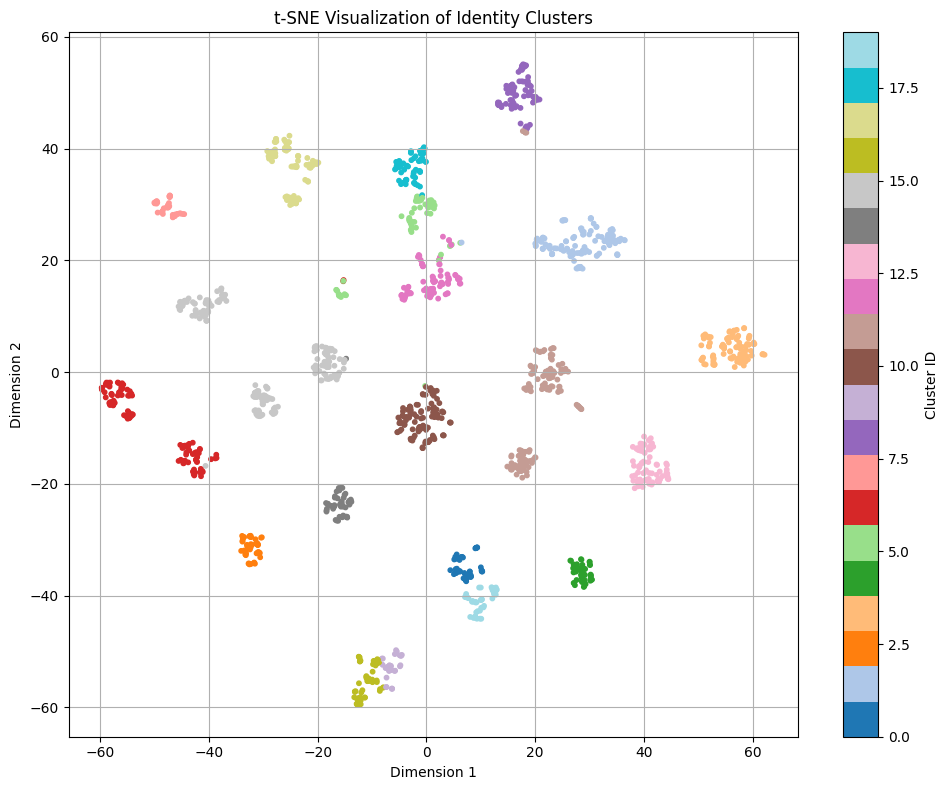

In [6]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert embeddings to NumPy array first!
embeddings_array = np.array(embeddings)

print("[INFO] Running t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Also make sure cluster_ids is a NumPy array
cluster_ids = np.array(cluster_ids)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_ids, cmap='tab20', s=10)
plt.colorbar(scatter, label='Cluster ID')
plt.title("t-SNE Visualization of Identity Clusters")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()
